# Imports

In [55]:
import pandas as pd
import numpy as np
import cv2
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from tensorflow import keras
from keras import layers, models, optimizers
from sklearn.model_selection import train_test_split


# Data Preprocessing

In [80]:
def get_df_from_dir(dir_path):
    imgs = []
    y = []
    for file in os.listdir(dir_path):
        path = dir_path + file
        img = cv2.imread(path)
        imgs.append(img)
    imgs = np.array(imgs)/255
    y = [0 if 'REAL' in dir_path else 1 for i in range(len(imgs))]
    return imgs, y

In [81]:
train_real_path = '../data/train/REAL/'
train_fake_path = '../data/train/FAKE/'
test_real_path = '../data/test/REAL/'
test_fake_path = '../data/test/FAKE/'

In [82]:
train_real_imgs, train_real_y = get_df_from_dir(train_real_path)
train_fake_imgs, train_fake_y = get_df_from_dir(train_fake_path)
test_real_imgs, test_real_y = get_df_from_dir(test_real_path)
test_fake_imgs, test_fake_y = get_df_from_dir(test_fake_path)

In [88]:
X = np.concatenate((train_real_imgs, train_fake_imgs))
y = np.concatenate((train_real_y, train_fake_y))
X_test = np.concatenate((test_real_imgs, test_fake_imgs))
y_test = np.concatenate((test_real_y, test_fake_y))

In [89]:
X.shape, y.shape, X_test.shape, y_test.shape

((100000, 32, 32, 3), (100000,), (20000, 32, 32, 3), (20000,))

In [90]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Model Training


In [91]:
def initialize_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [ ]:
def compile_model(learning_rate=1e-4):
    model = initialize_cnn_model()
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


In [ ]:
def train_model(
        X_train,
        y_train,
        X_val,
        y_val,
        epochs=100,
        batch_size=32,
        patience=5
        ):
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    model = compile_model()
    history = model.fit(
        X_train, 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val, y_val),
        callbacks=[es]
        )
    return model, history

In [109]:
model, history = train_model(X_train, y_train, X_val, y_val, epochs=1000, batch_size=32, patience=5)

Epoch 1/1000
2500/2500 [==============================] - 21s 8ms/step - loss: 0.4615 - accuracy: 0.7767 - val_loss: 0.4154 - val_accuracy: 0.8450
Epoch 2/1000
2500/2500 [==============================] - 21s 9ms/step - loss: 0.3393 - accuracy: 0.8548 - val_loss: 0.3572 - val_accuracy: 0.8716
Epoch 3/1000
2500/2500 [==============================] - 21s 8ms/step - loss: 0.2902 - accuracy: 0.8793 - val_loss: 0.3152 - val_accuracy: 0.8903
Epoch 4/1000
2500/2500 [==============================] - 21s 8ms/step - loss: 0.2675 - accuracy: 0.8891 - val_loss: 0.2801 - val_accuracy: 0.8988
Epoch 5/1000
2500/2500 [==============================] - 21s 8ms/step - loss: 0.2532 - accuracy: 0.8970 - val_loss: 0.2678 - val_accuracy: 0.9118
Epoch 6/1000
2500/2500 [==============================] - 21s 9ms/step - loss: 0.2397 - accuracy: 0.9034 - val_loss: 0.2734 - val_accuracy: 0.9025
Epoch 7/1000
2500/2500 [==============================] - 23s 9ms/step - loss: 0.2291 - accuracy: 0.9077 - val_loss: 0

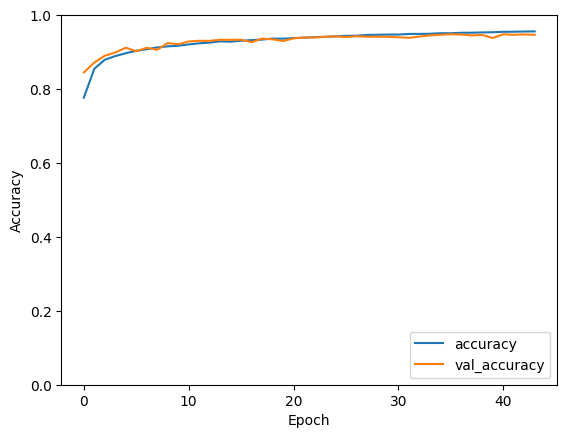

In [110]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)

In [111]:
train_accuracy = history.history['accuracy'][-1]
train_accuracy

0.9559624791145325

In [112]:
test_accuracy = model.evaluate(X_test, y_test)[1]

625/625 [==============================] - 2s 3ms/step - loss: 0.1410 - accuracy: 0.9459


In [113]:
test_accuracy

0.9459499716758728